In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import imaplib
import email
import os
import poplib
import getpass

import plotly
import plotly.plotly as py
from plotly import tools
from plotly.tools import FigureFactory as FF
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

from os import listdir
from os.path import isfile, join
 


pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [168]:
#read from xl csv...
df = pd.read_excel('CaraHittahV2.xlsx', sheet_name=None, ignore_index = False, sort=True)
cdf = pd.concat(df.values())

In [169]:
#the CSV is a bit of a mess - we take first row as the header, and start from row 2
#cdf.head()
cdf.columns = cdf.iloc[1, :]
cdf = cdf.iloc[2:, :]

In [195]:
#drop some columns - interesting way to do it by subsetting columns

hx = cdf[[                 'AB',                'Date',            
         'Strike Zone Width',                  'BV',               'POI X',
              'Bat Material',     'Impact Momentum',        'Horiz. Angle',
                                         'Dist',             'P. Type',
        'Strike Zone Bottom',                 'Pts',                'Velo',
         'Vertical Distance',               'Pitch',                'User',
                     'POI Y',                 'Res',   'Trigger to Impact',
                         
                         'Horizontal Distance',     'Strike Zone Top',
                'Hand Speed',                  'LA',          'Time Stamp',
               'Strike Zone',                                  'POI Z',
                        'AA',                'Type',  'Pitch Angle', 
          'Batting', 'Level', 'Barrel'  ]]

hx['BPower'] = 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [213]:
hx.sample(60)

1,AB,Date,Strike Zone Width,BV,POI X,Bat Material,Impact Momentum,Horiz. Angle,Dist,P. Type,Strike Zone Bottom,Pts,Velo,Vertical Distance,Pitch,User,POI Y,Res,Trigger to Impact,Horizontal Distance,Strike Zone Top,Hand Speed,LA,Time Stamp,Strike Zone,POI Z,AA,Type,Pitch Angle,Batting,Level,Barrel,BPower
514,2,28:09.7,17,0,-3.79,Undefined,0,-13,26,NaN,20.3,25,91.2,-7.6,76.4,Kairee Tekra,23.1,2018-06-03 00:00:00,0,3.2,39.4,0,-2,07:40.2,9,28.04,0,GB,NaN,NaN,NaN,0,0
258,23,30:53.5,17,0,0,Undefined,0,-19,151,NaN,21.9,58,89.3,-2.3,67.3,Tony Henricksen,0,F6,0,0.4,41.2,0,8,19:55.3,5,0,0,LD,-5.5,Right,Baseball - College,0,0
213,6,08:14.7,17,0,8.82,Undefined,0,-8,5,NaN,23.9,0,52.6,-9.5,65.9,Ian McIntyre,40.77,2018-06-03 00:00:00,0,-3.5,43.5,0,33,32:35.6,7,111.59,0,FB,-6.5,Right,Baseball - College,0,0
214,1,2018-10-04 19:33:34.163000,17,0,5.87,Undefined,0,84,191,NaN,24.7,0,66.8,5.2,74.8,Davis Sims,40.3,Foul,0,-6.2,44.5,0,57,00:11:27.043000,1,24.2,0,FB,-2.7,Right,Baseball - Professional,0,0
14,6,36:46.5,17,0,0.85,Undefined,0,5,323,NaN,23.5,105,100.7,-4.8,70.3,Jacob Bockelie,28.28,F8,0,-0.7,43.1,0,17,13:53.6,8,15.28,0,LD,-4.1,Left,Baseball - Professional,1,0
568,1,37:42.5,17,0,0.98,Undefined,0,-5,375,NaN,23.9,121,96.9,-5.3,71.9,Bo McClintock,29.26,2B-8,0,-1.6,43.5,0,26,00:14.6,8,27.03,0,FB,NaN,NaN,NaN,NaN,0
19,12,27:33.2,17,0,5.55,Undefined,0,-11,302,NaN,22.3,124,99.1,-6.1,63.6,Jared Wade,30.08,3B-8,0,-4.4,41.7,0,17,05:41.7,7,43.86,0,LD,NaN,NaN,NaN,1,0
360,04:33.4,0:-12:-12.-845,17,0,-4.59,NaN,0,-36,201,NaN,22.7,36,74,-2.9,NaN,NaN,31.83,1B-7,0,4.5,42.1,0,20,45.2,6,29.34,0,LD,NaN,NaN,NaN,0,0
357,30,24:50.9,17,0,4.01,Undefined,0,-17,178,NaN,23.1,74,93,-5.5,67.1,Aaron Lopez,28.73,F6,0,-5,42.6,0,9,22:48.3,7,26.97,0,LD,-4.8,Right,Baseball - College,0,0
94,19,2018-08-20 22:02:19.567000,17,0,-2.21,Undefined,0,54,185,NaN,22.7,0,64.3,-5.2,65,Marcos Figueroa,29.19,Foul,0,2.9,42.1,0,55,00:27:32.910000,9,31.89,0,FB,-4.7,Right,Baseball - College,0,0


In [206]:
def removefloats(row):
    if type (row['User']) == float:
        return "dummy"
    else:
        return(row['User'])

In [218]:
def setBarrelPower(row):
    if (type(row['Velo']) == float) or (type(row['Velo']) == int):
        V = row['Velo']
    else:
        return 0
    if (type(row['LA']) == float) or (type(row['LA']) == int):
        LA= row['LA']
    else:
        return 0
    
    BPower = 0
    
    if ( ((row['LA'] >= 8) and (row['LA'] <= 32)) and (row['Velo'] >= 102) ):
        BPower = 1
    if ( ((LA >= 12) and (LA <= 30)) and (V >= 99) ):
        BPower = 1
    if ( ((LA >= 16) and (LA <= 28)) and (V >= 95) ):
        BPower = 1
    if ( ((LA >= 20) and (LA <= 27)) and (V >= 90) ):
        BPower = 1
    if ( ((LA >= 24) and (LA < 26)) and (V >= 87) ):
        BPower = 1
    return(BPower)

In [172]:
## We are not using thing function ... it has a small problem 
#the function reads in an XLS file with multiple sheets, and returns a dateframe
#function doesnt do much validation that each sheet uses consistent format
#see helper documents for format of each sheet
def readdata(filename):
    xlsx = pd.ExcelFile(filename)

#initialize hitters_sheet
    hitters_sheets = []
    nsheet = xlsx.parse(xlsx.sheet_names[0])
    cols = nsheet.iloc[1, :]
    print(nsheet.shape, len(cols))
    nsheet.columns = cols
    nsheet = nsheet.iloc[2:,]
    hitters_sheets.append(nsheet)

    for isheet in range(1, len(xlsx.sheet_names)):
        nsheet = xlsx.parse(xlsx.sheet_names[isheet])
        if nsheet.shape[0] < 2:
            continue
        #print(nsheet.shape)
        nsheet = nsheet.iloc[2:, 0:53]
        #nsheet = nsheet.iloc[1:,]
        nsheet.columns = cols
        hitters_sheets.append(nsheet)
    
    hitters = pd.concat(hitters_sheets)
    return(hitters)


In [219]:
hx2 = hx.rename(index=str,columns={'POI X':'X','POI Y':'Y'}) 
hx2['User'] = hx2.apply(removefloats,axis=1)
hx2['BPower'] = hx2.apply(setBarrelPower, axis=1)
hx2 = hx2[(hx2.User!='User') & (hx2.User != 'dummy')]
hx2 = hx2[hx2.User.notna()]

In [220]:
Barrel = hx2.Barrel.dropna()
Barrel.count()
Barrel.sum()/Barrel.count()
B = hx2.BPower.sum()
B
hx2.sample(40)

1,AB,Date,Strike Zone Width,BV,X,Bat Material,Impact Momentum,Horiz. Angle,Dist,P. Type,Strike Zone Bottom,Pts,Velo,Vertical Distance,Pitch,User,Y,Res,Trigger to Impact,Horizontal Distance,Strike Zone Top,Hand Speed,LA,Time Stamp,Strike Zone,POI Z,AA,Type,Pitch Angle,Batting,Level,Barrel,BPower
386,8,45:57.8,17,0,-1.56,Undefined,0,-9,250,NaN,23.1,99,94.8,-9.3,66.3,Aaron Lopez,25.17,2B-8,0,1.9,42.6,0,14,11:04.4,8,27.47,0,LD,-5.3,Right,Baseball - College,1,0
227,53,15:22.1,17,0,0.28,Undefined,0,-23,281,NaN,22.7,54,81.4,-0.5,65.7,Nic Roes,32.86,F7,0,-0.7,42.1,0,26,25:03.3,5,24.51,0,FB,-4.4,Right,Baseball - College,0,0
481,23,28:48.2,17,0,2.68,Undefined,0,-2,194,NaN,23.1,87,94.6,-3,67.4,Aaron Lopez,29.7,1B-8,0,-2.6,42.6,0,10,24:15.3,5,16.07,0,LD,NaN,NaN,NaN,0,0
503,5,26:23.2,17,0,0.23,Undefined,0,-27,299,NaN,23.9,98,94.7,-7.3,74.1,Bo McClintock,27.73,F7,0,1.3,43.5,0,18,06:48.4,8,34.92,0,LD,NaN,NaN,NaN,NaN,0
134,9,2018-08-27 21:37:41.474000,17,0,-2.24,Undefined,0,-58,10,NaN,22.7,0,62.3,-4.5,64.3,Marcos Figueroa,30.36,Foul,0,1.3,42.1,0,-15,00:10:56.621000,8,35.3,0,GB,-4.6,Right,Baseball - College,0,0
121,2,2018-08-24 17:31:24.861000,17,0,3.24,Undefined,0,-25,320,NaN,23.9,58,83.3,3,71.7,Thomas Reindl,38.3,F7,0,-3,43.5,0,33,00:04:37.647000,4,44.71,0,FB,-2,Right,Baseball - College,0,0
109,4,27:28.7,17,0,6.2,Undefined,0,-16,10,NaN,21.9,0,83.9,-5.6,73.9,Aiden Ferry,27.75,2018-06-03 00:00:00,0,-7.4,41.2,0,-14,09:03.4,7,30.34,0,GB,-4.5,Right,Baseball - Professional,0,0
293,1,42:13.4,17,0,-0.51,Undefined,0,-29,232,NaN,21.9,75,95.4,-4,68,Eric Kozak,30.06,F7,0,-1,41.2,0,12,08:06.0,8,35.78,0,LD,-4.7,Right,Baseball - Professional,1,0
654,46,17:56.2,17,0,0,Undefined,0,-5,338,NaN,23.1,61,85.1,-32.9,0,Aaron Lopez,0,F8,0,0,42.6,0,37,22:57.1,NaN,0,0,FB,NaN,NaN,NaN,0,0
372,7,28:07.2,17,0,-8.11,Undefined,0,-37,309,NaN,21.9,101,98.7,-2.6,72.3,Eric Kozak,31.51,1B-7,0,8.2,41.2,0,17,00:49.6,6,34.54,0,LD,-5,Right,Baseball - Professional,1,1


In [176]:
#return average, max, min velocity by strikezone
def velobyzone(df, zone):
    dfx = df[df['Strike Zone']== zone]
    s = dfx.Velo.sum()
    c = dfx.Velo.count()
    a = round(s/c,1)
    m = round(dfx.Velo.max(),1)
    n = round(dfx.Velo.min(),1)
    return a, m
    

In [258]:
#function returns flybal, ground ball, line drive % by strike zone grid

def hittingbyzone(df, zone):
    
    if zone != 0:
        dfx = df[df['Strike Zone']== zone]
    else:
        #overall statistics
        dfx = df
    
    if dfx.shape[0] == 0:
        gb = 0.0
        ld = 0.0
        fb = 0.0
        a = 0.0
        m = 0.0 
        tup = (fb, gb, ld, a, m)
        return tup
    
    s = dfx.Velo.sum()
    c = dfx.Velo.count()
    a = round(s/c,1)
    m = round(dfx.Velo.max(),1)
    #n = round(dfx.Velo.min(),1)
    
    dfx = dfx.groupby(['Type']).count()
    y = dfx.shape
    s = dfx.iloc[:, 0].sum()
    if y[0] < 2:
        gb = 0.00
    else:
        gb = round(dfx.iloc[1,0]/s, 2)
    if y[0] < 3:
        ld = 0.00
    else:             
        ld = round(dfx.iloc[2,0]/s, 2)
    fb = round(dfx.iloc[0,0]/s, 2)
    
    siz = dfx.shape[0]
    barrel = dfx.BPower.sum()
    bbiq = round((barrel/siz), 2)
    
    tup = (fb, gb, ld, a, m, bbiq)
    return tup

In [259]:
hittingbyzone(maxdutto,2)

(0.33, 0.67, 0.0, 85.2, 96.2, 1.5)

In [260]:
def gethitterstats(df, hittername):
    
    alist = []
    cols  = ['Fly Balls', 'Ground Balls', 'Line Drive', 'AvgExitVelo', 'Max Exit Velo', 'Barrel-BBE%']
    idx = ['Zone 1', 'Zone 2', 'Zone 3', 'Zone 4', 'Zone 5', 'Zone 6', 'Zone 7', 'Zone 8', 'Zone 9', 'Overall']
    if hittername != 'All':
        dfx = df[df.User == hittername]
    else:
        dfx = df
    
    for i in range(1, 10):
        tup = hittingbyzone(dfx, i)
        alist.append(tup)
        
    tup = hittingbyzone(dfx,0)
    alist.append(tup)
        
    #print (alist)
    
    hstats = pd.DataFrame(alist, index = idx, columns = cols)
    return(hstats)

In [261]:
hstats = gethitterstats(hx2, 'Max Dutto')
hstats

,Fly Balls,Ground Balls,Line Drive,AvgExitVelo,Max Exit Velo,Barrel-BBE%
Zone 1,0.00,0.00,0.00,0.0,0.0,NaN
Zone 2,0.67,0.33,0.00,80.7,85.8,1.50
Zone 3,0.00,0.00,0.00,0.0,0.0,NaN
Zone 4,0.64,0.18,0.18,84.4,93.7,3.67
Zone 5,0.56,0.04,0.40,79.4,96.6,8.33
Zone 6,0.43,0.43,0.14,88.1,95.4,2.33
Zone 7,0.39,0.26,0.35,86.7,98.8,7.67
Zone 8,0.22,0.24,0.53,87.4,98.6,15.00
Zone 9,0.33,0.08,0.58,86.1,96.9,4.00
Overall,0.36,0.24,0.40,84.1,98.8,48.00


In [252]:
def homeplate():
    plt.figure(figsize=(8,12),dpi=80)
    plt.xlim(-18,18)
    plt.ylim(0,60)

    xmin = -8.5
    xmax = 8.5
    ymin = 23.1
    ymax = 44.6
    deltax = (xmax-xmin)/3
    deltay = (ymax-ymin)/3

    xtick = [xmin, xmin+deltax, xmin+(2*deltax), xmax]
    ytick = [ymin, ymin+deltay, ymin+(2*deltay), ymax]

    X1 = np.linspace(xmin,xmax,4)
    Y1 = np.linspace(ymin,ymax,4)
    Y2 = np.linspace(ymin,ymin,4)
    X2 = np.linspace(xmin,xmin,4)
    X3 = np.linspace(xmax,xmax,4)
    Y3 = np.linspace(ymax,ymax,4)


    X4 = np.linspace(xtick[1],xtick[1],4)
    X5 = np.linspace(xtick[2],xtick[2],4)
    Y4 = np.linspace(ytick[1],ytick[1],4)
    Y5 = np.linspace(ytick[2],ytick[2],4)


    plt.plot(X1,Y2,c='black')
    plt.plot(X2,Y1,c='black')
    plt.plot(X1,Y3,c='black')
    plt.plot(X3,Y1,c='black')


    plt.plot(X4,Y1,c='black',linestyle= '--')
    plt.plot(X5,Y1,c='black',linestyle= '--')
    plt.plot(X1,Y4,c='black',linestyle= '--')
    plt.plot(X1,Y5,c='black',linestyle= '--')
    deltax2 = deltax * 0.6
    deltay2 = deltay * 0.6
    x0 = xmin - deltax2
    x6 = xmax + deltax2
    y0 = ymin - deltay2
    y6 = ymax + deltay2
    yhalf = (ymax+ymin) * 0.5
    xhalf = (xmax + xmin) * 0.5
    
    X0 = np.linspace(x0, x6, 4)
    X6 = np.linspace(x0, x0, 4)
    X7 = np.linspace(x6, x6, 4)
    Y0 = np.linspace(y0, y6, 4)
    Y6 = np.linspace(y0, y0, 4)
    Y7 = np.linspace(y6, y6, 4)
    
    X10 = np.linspace(x0, xmin, 4)
    X11 = np.linspace(xmax, x6, 4)
    X12 = np.linspace(xhalf, xhalf, 4)
    Y10 = np.linspace(y0, ymin, 4)
    Y11 = np.linspace(ymax, y6, 4)
    Y12 = np.linspace(yhalf, yhalf, 4)
    
    plt.plot(X0, Y6, c='red')
    plt.plot(X0, Y7, c='red')
    plt.plot(X6, Y0, c='red')
    plt.plot(X7, Y0, c='red')
    
    plt.plot(X10, Y12, c='red')
    plt.plot(X11, Y12, c='red')
    plt.plot(X12, Y10, c='red')
    plt.plot(X12, Y11, c='red')



In [253]:
def analyze(hx2,username,date1,date2,v1,v2):
    
    #subset by player .. 
    hnew = hx2[hx2.User == username]
    
    Vmax = 90
    Vlow = 83
   
    LAopt1 = 10
    LAopt2 = 30
    LAbad = 0
    
    
    homeplate()
    #plt.scatter(hnew.X,hnew.Y)
    #h1 = hnew[(hnew.LA<5)]
    h0  = hnew[(hnew.LA>10)&(hnew.LA < 30)]
    h00 = h0[h0.Velo >= 90]
    h01 = h0[(h0.Velo <90) & (h0.Velo >83)]
    h02 = h0[h0.Velo <= 83]
    
    h1 = hnew[(hnew.LA > 0) & (hnew.LA <10)]
    h10 = h1[h1.Velo>=90]
    h11 = h1[(h1.Velo>83) & (h1.Velo <90)]
    h12 = h1[h1.Velo< 83]
    
    h2 = hnew[hnew.LA < 0]
    h20 = h2[h2.Velo >= 90]
    h21 = h2[(h2.Velo > 83) & (h2.Velo <90)]
    h22 = h2[h2.Velo <= 83]
    
    h3 = hnew[hnew.LA > 30]
    h30 = h3[h3.Velo >= 90]
    h31 = h3[(h3.Velo > 83) & (h3.Velo <90)]
    h32 = h3[h3.Velo <= 83]
    
    #x = hnew.X
    #y=hnew.Y
    plt.scatter(h00.X,h00.Y, c='darkgreen',s=30, label='EV>90, LA 10-30')
    plt.scatter(h01.X, h01.Y, c ='green',s=30,marker='*', label='EV 83-90, LA 10-30')
    plt.scatter(h02.X, h02.Y, c='limegreen', s=30, marker='v', label='EV<83, LA10-30')
     
    plt.scatter(h10.X,h10.Y, c='darkblue',s=30, label='EV>90, LA 0-10')
    plt.scatter(h11.X, h11.Y, c ='mediumblue',s=30,marker='*', label='EV 83-90, LA 0-10')
    plt.scatter(h12.X, h12.Y, c='blue', s=30, marker='v', label='EV<83, LA 0=10') 
    
    plt.scatter(h20.X,h20.Y, c='red',s=30, label='EV>90, LA <0')
    plt.scatter(h21.X, h21.Y, c ='darkred',s=30,marker='*', label='EV 83-90, LA <0')
    plt.scatter(h22.X, h22.Y, c='orangered', s=30, marker='v', label='EV<83, LA <0') 
    
    plt.scatter(h30.X,h30.Y, c='magenta',s=30, label='EV>90, LA >30')
    plt.scatter(h31.X, h31.Y, c ='fuchsia',s=30,marker='*', label='EV 83-90, LA >30')
    plt.scatter(h32.X, h32.Y, c='orchid', s=30, marker='v', label='EV<83, LA >30')
    
    plt.xlabel('Horizontal Location' )
    plt.ylabel('Vertical Location')
    plt.title(username)
    
    #return hnew
    plt.legend()
    plt.show()
    
    hstats = gethitterstats(hnew, 'All')
    return hstats

In [254]:
def doheatmaps(hstats):
    Z = hstats.loc[:, 'AvgExitVelo']
    Z = Z.tolist()
    Z = [Z[0:3], Z[3:6], Z[6:9]]
    LDz = hstats.loc[:, 'Line Drive']
    LD = LDz.tolist()
    LD = [LD[0:3], LD[3:6], LD[6:9]]
    hitterheatmap(Z,'Average Exit Velocity Heatmap')
    hitterheatmap(LD, 'Line Drive % Heatmap')

In [255]:
def hitterheatmap(Z, labelstring):
#fig = FF.create_annotated_heatmap(d, colorscale='Viridis')

#plotly.figure_factory.create_annotated_heatmap(d) 
#py.iplot(fig, filename='numpy-reshape-1')

    X = ['Left', 'Mid', 'Right']
    Y = ['Bottom', 'Mid', 'Top']

    trace = go.Heatmap(z=Z,x=X,y=Y)
    #Q = [ [12,14,8], [21,33,44],[8,7,11] ]
    #trace2 = go.Heatmap(z=Q, x=X, y=Y)

    #fig = tools.make_subplots(rows=1, cols=2)
    #fig.append_trace(trace1, 1, 1)
    #fig.append_trace(trace2, 1, 2)
    data=[trace]
    layout = go.Layout(
        autosize=False,
        title=labelstring,
        width=480,
        height=600,
        margin=go.layout.Margin(
            l=75,
            r=50,
            b=100,
            t=100,
            pad=4
        ),
        paper_bgcolor='#7f7f7f',
        plot_bgcolor='#c7c7c7'
    )
    #fig['layout'].update(height=600, width=800, title='i <3 annotations and subplots')

    fig = go.Figure(data = data, layout=layout)
    plotly.offline.iplot(fig) 


In [256]:
def HitterSummary (hx2,hitter,date1,date2, v1, v2):
    hstats = analyze(hx2,hitter, date1, date2,v1, v2)
    
    doheatmaps(hstats)
    
    return (hstats)

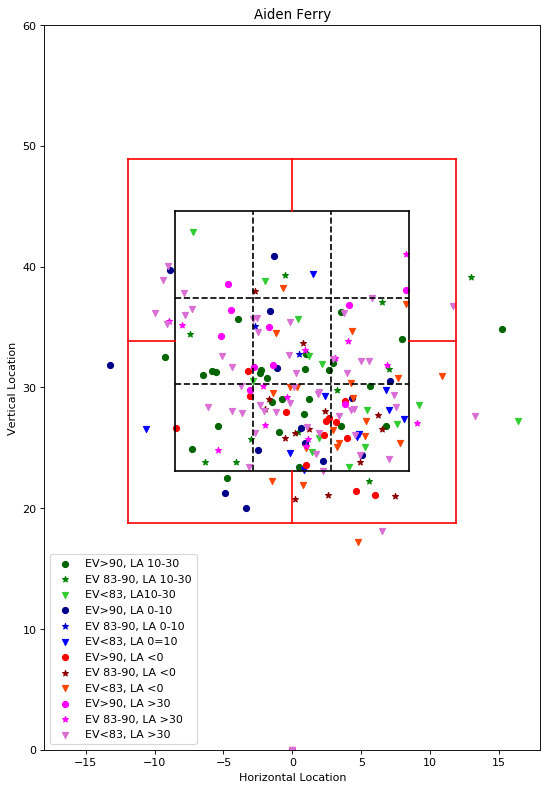

,Fly Balls,Ground Balls,Line Drive,AvgExitVelo,Max Exit Velo,Barrel-BBE%
Zone 1,0.60,0.20,0.20,83.8,99.1,1.67
Zone 2,0.20,0.20,0.60,77.3,97.0,1.67
Zone 3,0.75,0.25,0.00,77.2,98.4,2.00
Zone 4,0.57,0.13,0.30,84.2,102.9,7.67
Zone 5,0.56,0.26,0.19,81.2,102.4,9.00
Zone 6,0.70,0.10,0.20,81.1,99.3,6.67
Zone 7,0.28,0.56,0.15,76.6,96.9,13.00
Zone 8,0.33,0.43,0.24,83.1,101.8,18.00
Zone 9,0.57,0.07,0.36,87.0,102.4,4.67
Overall,0.43,0.31,0.25,81.3,102.9,70.67


In [262]:
hstats  = HitterSummary(hx2, 'Aiden Ferry', 44,55, 60, 90)
hstats

In [188]:
hstats

,Fly Balls,Ground Balls,Line Drive,AvgExitVelo,Max Exit Velo
Z 1,0.0,0.0,0.0,0.0,0.0
Z 2,0.7,0.3,0.0,80.7,85.8
Z 3,0.0,0.0,0.0,0.0,0.0
Z 4,0.6,0.2,0.2,84.4,93.7
Z 5,0.6,0.0,0.4,79.4,96.6
Z 6,0.4,0.4,0.1,88.1,95.4
Z 7,0.4,0.3,0.3,86.7,98.8
Z 8,0.2,0.2,0.5,87.4,98.6
Z 9,0.3,0.1,0.6,86.1,96.9
